# Scientific Programming in Python
## Final Project
## _Jeelka Hessenius and Luca Saur_


In [84]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


## Data loading
### Moodnoodles Data

**Moodnoodles** is a website built by Luca that allows you to track wellbeing, habits and other things. It has been used daily by Jeelka and Luca for the past two months to generate the dataset we are using for this project. Please visit <https://moodnoodles.com> to familiarize yourself with the setup.

We have chosen a **subset** of our tracked data and exported it as csv file. In the following code block we load the data and refactor the complicated user_id for simplicity purposes so that now Luca's user_id is 1 and Jeelka's is 0.
### Clockify Data

Additionally, we track work time using Clockify. For their set-up check out <https://app.clockify.me/tracker>. In general, we make sure to track the minimal work-time possible such that short breaks etc. are not included. Even though in Clockify we track work-time per project, for this assignment we decided to export our data grouped by day. This is because we are interested in how our total work-time per day affected our well-being without considering the effect of working on specific projects.

In the code block below we read in the data from our Clockify data set and select the relevant columns "Date" and "Time..decimal.". Converting the "Date" column into date format will later help us to join this dataframe onto our main data set.

### Load in and clean up data

In [85]:
# Load data
# wellbeing.csv containts the self reported data of two participants
df = pd.read_csv('data/wellbeing.csv')

# worktime_jeelka.csv and worktime_luca.csv contain the worktime data of the two participants
df_wt_0 = pd.read_csv('data/worktime_jeelka.csv')
df_wt_1 = pd.read_csv('data/worktime_luca.csv')

# drop User column because we user_id from wellbeing.csv later (only participant 1 has it)
# Also drop Amount column because we don't need it
df_wt_0.drop(columns=['User', 'amount'], inplace=True)
df_wt_1.drop(columns=['amount'], inplace=True)

# drop time (h) because we use time decimal
df_wt_0.drop(columns=['Time (h)'], inplace=True)
df_wt_1.drop(columns=['Time (h)'], inplace=True)

# Rename Date column to match date from wellbeing.csv and Time (decimal) to worktime
df_wt_0.rename(columns={'Date': 'date', 'Time (decimal)': 'worktime'}, inplace=True)
df_wt_1.rename(columns={'Date': 'date', 'Time (decimal)': 'worktime'}, inplace=True)

# convert all to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=False)
df_wt_0['date'] = pd.to_datetime(df_wt_0['date'], dayfirst=True)
df_wt_1['date'] = pd.to_datetime(df_wt_1['date'], dayfirst=True)

# convert uuid user_ids to binary (two people in this data set)
df['user_id'] = df['user_id'].apply(lambda x: 0 if x in "e0e084c5-2308-4080-b217-90d5875fa312" else 1)
df_0 = df[df['user_id'] == 0]
df_1 = df[df['user_id'] == 1]

# drop user_id in the dataframes, because it is implied by the dataframe used
df_0 = df_0.drop(columns=['user_id'])
df_1 = df_1.drop(columns=['user_id'])

# merge worktime and wellbeing data for each person
df_0 = df_0.merge(df_wt_0, on='date').reset_index(drop=True)
df_1 = df_1.merge(df_wt_1, on='date').reset_index(drop=True)

# show one data frame to inspect it
df_1

,date,wellbeing,meditated,sleep_time,did_sport,steps,sweets,walk,worktime
0,2024-12-21,6,False,8.5,False,11000,NaN,NaN,7.30
1,2024-12-22,7,True,8.0,True,7000,NaN,NaN,2.03
2,2024-12-27,6,True,9.0,False,8700,True,True,3.42
3,2024-12-23,6,True,8.0,False,17000,NaN,NaN,3.96
4,2024-12-25,6,True,8.0,False,14000,True,True,5.02
5,2024-12-26,6,True,7.0,False,9500,True,True,1.81
6,2024-12-30,6,True,7.5,False,6000,True,True,0.39
7,2024-12-28,7,False,8.0,False,11000,True,True,2.53
8,2024-12-29,6,True,7.5,True,2000,True,False,0.38
9,2024-12-31,7,True,7.5,False,23000,True,True,2.95


### Wellbeing histogram of both participants

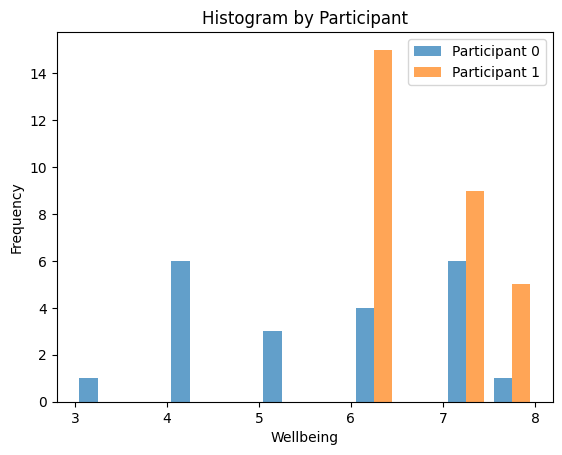

In [86]:
# plot the wellbeing histogram of both participants
plt.hist([df_0['wellbeing'], df_1['wellbeing']], bins=10, alpha=0.7, label=['Participant 0', 'Participant 1'])
# add labels and title
plt.xlabel('Wellbeing')
plt.ylabel('Frequency')
plt.title('Histogram by Participant')
plt.legend()
plt.show()

As we can see the two participants have a different wellbeing distribution.
Participant 0 has an overall higher varience, with potentially lower values of wellbeing.
Participant 1 has a tighter distribution, with most values falling on the value 6, and a few values on the 7 and 8.

### Worktime histogram of both participants

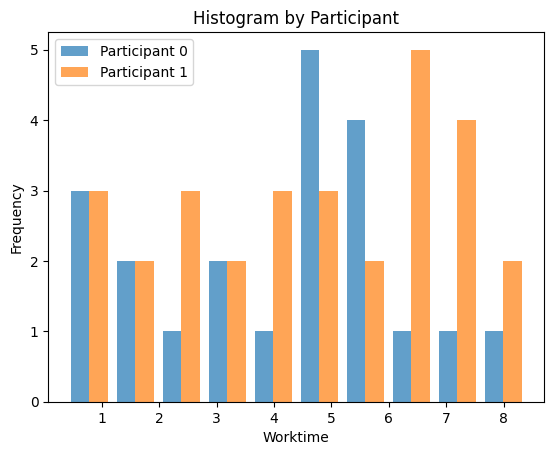

In [87]:
# plot the worktime histogram of both participants
plt.hist([df_0['worktime'], df_1['worktime']], bins=10, alpha=0.7, label=['Participant 0', 'Participant 1'])
# add labels and title
plt.xlabel('Worktime')
plt.ylabel('Frequency')
plt.title('Histogram by Participant')
plt.legend()
plt.show()

We can see that the two participants have relativly similar worktime distributions. 
Except for Participant 1 who has more days in the higher worktime range from 6 to 8 hours.

### Correlation matrix of sample participant 1

In [88]:
df_1.corr()

,date,wellbeing,meditated,sleep_time,did_sport,steps,sweets,walk,worktime
date,1.000000,0.513929,0.364762,-1.415355e-01,0.612228,-0.161431,-4.909248e-01,0.237432,0.536526
wellbeing,0.513929,1.000000,0.083641,-6.978269e-02,0.243610,0.235129,-1.252508e-01,0.212417,0.340125
meditated,0.364762,0.083641,1.000000,-1.236957e-01,0.283315,-0.088005,-1.649572e-01,-0.047619,-0.058381
sleep_time,-0.141535,-0.069783,-0.123696,1.000000e+00,-0.268677,-0.102134,7.502999e-16,0.166398,0.152095
did_sport,0.612228,0.243610,0.283315,-2.686775e-01,1.000000,-0.269558,-3.779645e-01,-0.218218,0.245122
steps,-0.161431,0.235129,-0.088005,-1.021337e-01,-0.269558,1.000000,-1.249400e-02,0.383278,0.052862
sweets,-0.490925,-0.125251,-0.164957,7.502999e-16,-0.377964,-0.012494,1.000000e+00,-0.164957,-0.416272
walk,0.237432,0.212417,-0.047619,1.663984e-01,-0.218218,0.383278,-1.649572e-01,1.000000,0.380926
worktime,0.536526,0.340125,-0.058381,1.520947e-01,0.245122,0.052862,-4.162716e-01,0.380926,1.000000


We can see that there not that many strong correlations with wellbeing for this participant.
Notably, time (0.34), date(0.51) seem have to a decent correlation with wellbeing. Date is particularly interesting because it implies that from the start of the data collection, wellbeing has increased. Maybe due to some kind of inflation of rating wellbeing.

There seem to be some weak correlations with did_sport (0.24), walk(0.21) and steps (0.23) which we will examine later.

Other funny correlations are a negative correlation of (-0.37) of sweets and sport, and a negative correlation of (-0.41) of sweets and time.

### Scatter plot of time and wellbeing for Participant 1


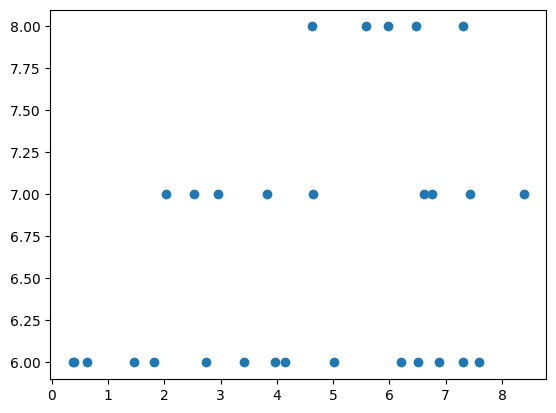

In [89]:
plt.scatter(df_1['worktime'], df_1['wellbeing'])
plt.show()

We can already see a positive correlation between time and wellbeing, indicated by the slope of the scatter plot.
This could mean that higher hours of work are associated with higher wellbeing.

### Predicting wellbeing based on work time for one participant in a simple linear regression model


Coefficient (slope): 0.0956
Intercept: 6.1948
R-squared Score: 0.2520


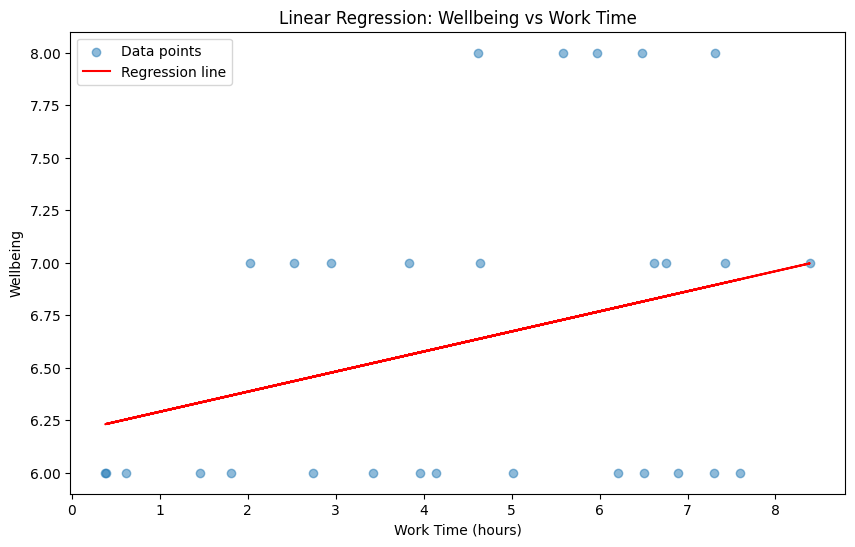

In [90]:
# Prepare the data (using only 'time' as feature)
X_time = df_1[['worktime']].values
y = df_1['wellbeing'].values

# Split the data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_time, y, test_size=0.2, random_state=42
)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
# calculate r2 score
r2 = r2_score(y_test, y_pred)

print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Visualize the regression line
plt.figure(figsize=(10, 6))
# scatter plot of the data
plt.scatter(df_1['worktime'], df_1['wellbeing'], alpha=0.5, label='Data points')
# plot the regression line
plt.plot(X_time, model.predict(X_time), color='red', label='Regression line')
# add labels and title
plt.xlabel('Work Time (hours)')
plt.ylabel('Wellbeing')
plt.title('Linear Regression: Wellbeing vs Work Time')
plt.legend()
plt.show()

The output looks quite good, especially considering we are only using one feature.
An R-squared score of 0.25 means that the model explains 25% of the variance in the data, just based on work time. Which is impressive.
The positive slope means that the more work time, the higher the wellbeing, which fits the correlation we saw in the scatter plot.

## Predicting wellbeing with a neural network

### First: Testing our approach on surrogate data to see if the NN is able to recover the parameters from the surrogate data and to see if our approach works in principle

In [91]:

### Lets create some surrogate data and train a nn on it

np.random.seed(42) # set a random seed for the numpy
torch.manual_seed(42) # set a random seed for the pytorch
num_features = 6 # number of numerical features
boolean_features = 0 # number of boolean features
total_features = num_features + boolean_features # total number of features

# Create a simple function to generate surrogate data
def generate_surrogate_data(n_samples=50, n_num_features=6, n_boolean_features=0):
    """
    Generate surrogate data with random correlations between features.
    """
    total_features = n_num_features + n_boolean_features
    # Generate random weights for each feature
    weights = np.random.uniform(-1, 1, total_features)
    # Generate random data
    boolean_data = np.random.randint(0, 2, (n_samples, n_boolean_features))
    num_data = np.random.randn(n_samples, n_num_features)
    data = np.concatenate([boolean_data, num_data], axis=1)
    
    # Calculate the target as a linear combination of the features
    target = np.dot(data, weights) 
    return data, target, weights

# Generate surrogate data
data, target, original_weights = generate_surrogate_data(n_num_features=num_features, n_boolean_features=boolean_features)

# Split the data into training and test set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Train a neural network on the surrogate data
# We will use the same architecture for the real model
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(total_features, 1),
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

net = Net2()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# We will train the nn for 100 epochs
for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

with torch.no_grad():
    test_outputs = net(X_test_tensor)
    test_loss = loss_fn(test_outputs, y_test_tensor)
    
    y_pred = test_outputs.detach().numpy()  # Proper tensor conversion
    y_true = y_test_tensor.numpy()  # Ensure y_test is also NumPy

    # Compute R²
    r2 = r2_score(y_true, y_pred)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))

    # Relative Error (RE) - with division safety
    re = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))
    print("--------------------------------")
    print(f"R-squared Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Relative Error: {re:.4f}")
    print("--------------------------------")

print("recovered weights")
print(net.linear_relu_stack[0].weight)
print("original weights")
print(original_weights)

Epoch 10, Loss: 1.2090
Epoch 20, Loss: 0.8224
Epoch 30, Loss: 0.5453
Epoch 40, Loss: 0.3424
Epoch 50, Loss: 0.2037
Epoch 60, Loss: 0.1159
Epoch 70, Loss: 0.0633
Epoch 80, Loss: 0.0333
Epoch 90, Loss: 0.0169
Epoch 100, Loss: 0.0083
--------------------------------
R-squared Score: 0.9941
Mean Absolute Error: 0.0806
Relative Error: 0.0624
--------------------------------
recovered weights
Parameter containing:
tensor([[-0.2440,  0.8934,  0.4376,  0.1920, -0.6808, -0.6073]],
       requires_grad=True)
original weights
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096]


As we can see, the nn is able to recover the parameters from the surrogate data with a high accuracy. 
Furthmore the error is very low, which is good. Even with a low number of samples (50) and a relativly low number of epochs (100), the nn is able to recover the parameters quite well.

To be fair, the data is very simple and only has this linear relationship, so it is not surprising that the nn is able to recover the parameters.

Lets see how well the nn performs on the real data.

#### 1. Defining two helper functions to visualize the neural network and to map the loss to a color

In [92]:
# Function to draw the neural network
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, model, loss):
    ax.axis('off')

    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Retrieve weights from the model
    weight = model.linear_relu_stack[0].weight.detach().numpy()

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        max_weight = np.max(np.abs(weight)) if n == 0 else 1  # Scale based on input weights if available
        for m in range(layer_size):
            size = v_spacing / 4. * (np.abs(weight[0, m]) / max_weight + 0.1) if n == 0 else v_spacing / 4.
            color = get_color_for_loss(loss) if n == len(layer_sizes) - 1 else 'w'
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), size, color=color, ec='k', zorder=4)
            ax.add_artist(circle)

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                x_coords = [n * h_spacing + left, (n + 1) * h_spacing + left]
                y_coords = [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing]
                line = plt.Line2D(x_coords, y_coords, c='k')
                ax.add_artist(line)
                # Display weight
                if n == 0:
                    ax.text((x_coords[0] + x_coords[1]) / 2, (y_coords[0] + y_coords[1]) / 2 + 0.02,
                            f"{weight[0, m]:.2f}", fontsize=16, va='center', ha='center', color='blue')

    plt.draw()


# Function to map loss to color
def get_color_for_loss(loss):
    if 25 < loss <= 50:
        return 'red'
    elif 15 < loss <= 25:
        return 'orange'
    elif 7 < loss <= 15:
        return 'yellow'
    else:  # 0 < loss <= 7
        return 'green'

#### 2. Preprocessing the data and splitting it into training and test set

In [93]:
# Concatenate the dataframes, to have more datapoints
df_all = pd.concat([df_0, df_1])
# drop index to avoid confusion
df_all.reset_index(drop=True, inplace=True)
# Fill NaN values with False, because we can't have NaNs in the boolean columns
df_all.fillna(False, inplace=True)

# Select the features and the target
# Features: meditated, sleep_time, did_sport, steps, sweets, walk, worktime
X = df_all[['sleep_time', 'worktime', 'sweets', 'meditated', 'did_sport', 'walk']]
# Convert boolean columns to int, to make them work with the nn
X = X.astype({'meditated': int, 'did_sport': int, 'walk': int, 'sweets': int})  # Convert boolean columns


# Target: wellbeing
y = df_all['wellbeing']

# Standardize the first two features, which are numerical, to improve the performance of the nn
scaler = StandardScaler()
X.iloc[:, :2] = scaler.fit_transform(X.iloc[:, :2])

# Convert to numpy arrays
X = X.to_numpy()
y = y.to_numpy()

# Convert to PyTorch tensors to make them accesible for the nn
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape y to be a column vector

# Split the data into training and test set (20% test set, 80% training set)
# We use training set to train the nn and test set to evaluate the performance of the nn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

/tmp/ipykernel_2967/2227948266.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all.fillna(False, inplace=True)


#### 3. Defining the neural network and fitting it

Epoch 10, Loss: 32.7927
Epoch 20, Loss: 29.0217
Epoch 30, Loss: 25.6379
Epoch 40, Loss: 22.6312
Epoch 50, Loss: 19.9712
Epoch 60, Loss: 17.6224
Epoch 70, Loss: 15.5521
Epoch 80, Loss: 13.7327
Epoch 90, Loss: 12.1396
Epoch 100, Loss: 10.7508
Epoch 110, Loss: 9.5462
Epoch 120, Loss: 8.5074
Epoch 130, Loss: 7.6170
Epoch 140, Loss: 6.8585
Epoch 150, Loss: 6.2166
Epoch 160, Loss: 5.6767
Epoch 170, Loss: 5.2253
Epoch 180, Loss: 4.8502
Epoch 190, Loss: 4.5402
Epoch 200, Loss: 4.2852
--------------------------------
R-squared Score: -2.2611
Mean Absolute Error: 1.7398
Relative Error: 0.3339
--------------------------------

Test Loss: 4.8590
--------------------------------
Parameter containing:
tensor([[0.5367, 0.3714, 1.0315, 1.7120, 1.4199, 1.6305]], requires_grad=True)
sleep_time    0.186973
worktime      0.035113
sweets       -0.198110
meditated     0.422435
did_sport    -0.198110
walk          0.302759
wellbeing     1.000000
Name: wellbeing, dtype: float64


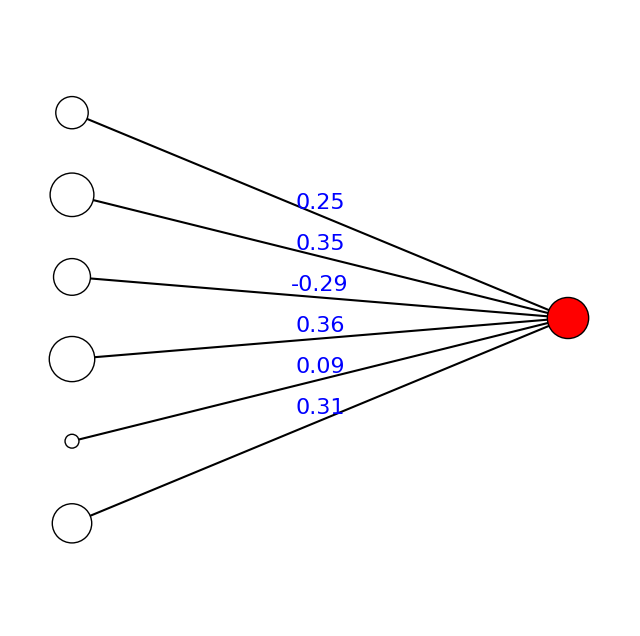

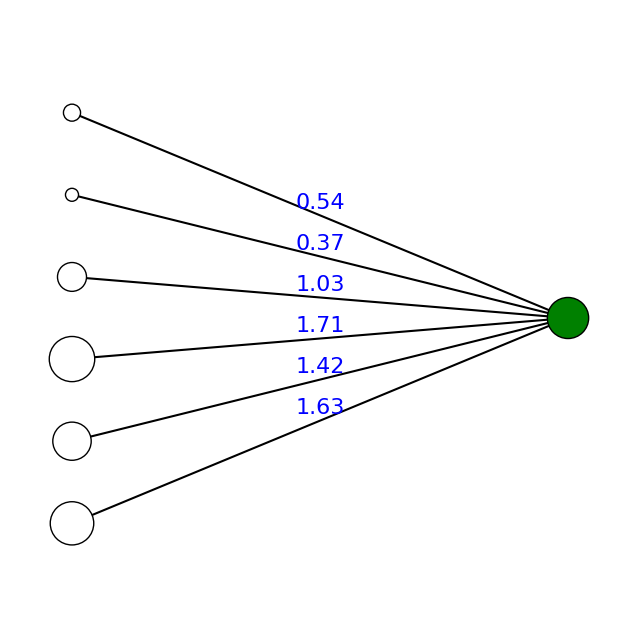

In [94]:
INPUT_LAYER_SIZE = 6 # Number of input features
OUTPUT_LAYER_SIZE = 1 # One output neuron for wellbeing

# Define the neural network using a single linear layer
# Same architecture as for the surrogate data
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(INPUT_LAYER_SIZE, OUTPUT_LAYER_SIZE),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# We chose a single linear layer, because of the small number of datapoints and features

# Initialize the neural network
net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(net.parameters(), lr=0.01) # Adam optimizer

# For plotting the nn, define two subplots
plt.ion() 
fig1, ax1 = plt.subplots(figsize=(8, 8))
fig2, ax2 = plt.subplots(figsize=(8, 8))
layer_sizes = [INPUT_LAYER_SIZE, OUTPUT_LAYER_SIZE]


# Train the network over 200 epochs
# We tested with higher and lower epochs, but 200 seemed to work quite well regarding the loss and error on the test set
for epoch in range(200):
    if epoch == 1:
        # draw the net at the beginning of the training
        draw_neural_net(ax1, .1, .9, .1, .9, layer_sizes, net, loss.item())
        time.sleep(1)
    if epoch == 199:
        # draw the net at the end of the training
        draw_neural_net(ax2, .1, .9, .1, .9, layer_sizes, net, loss.item())
        time.sleep(1)
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = net(X_train)
    # Compute the loss
    loss = criterion(outputs, y_train)
    # Backward pass
    loss.backward()
    # Update the weights
    optimizer.step()
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:  
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Turn off the interactive mode
plt.ioff()

# Test and evaluate the network
with torch.no_grad(): # use no_grad to avoid computing gradients
    # Forward pass
    test_outputs = net(X_test)
    # Compute the loss
    test_loss = criterion(test_outputs, y_test)
    # Detach the test outputs and convert to numpy
    y_pred = test_outputs.detach().numpy()
    y_true = y_test.numpy()

    # Compute R²
    r2 = r2_score(y_true, y_pred)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))

    # Relative Error (RE) - with division safety
    re = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))
    

    # Print the results of the test set
    print("--------------------------------")
    print(f"R-squared Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Relative Error: {re:.4f}")
    print("--------------------------------")

# Print the results of the test set
print(f"\nTest Loss: {test_loss.item():.4f}")

print("--------------------------------")
# If we use a single linear layer, we can recover the parameters from the network
print(net.linear_relu_stack[0].weight)

print(df_all[['sleep_time', 'worktime', 'sweets', 'meditated', 'did_sport', 'walk', 'wellbeing']].corr()['wellbeing'])

Looking at the loss over the training epochs, we can see that the loss is decreasing over the epochs, which is good. 
The decline rate of the loss decreases and the difference in loss for the last epochs is very small.

The R-squared score is negative, which is bad. This means that the model is worse than simply predicting the mean of the wellbeing of the participants.

The mean absolute error is 1.74, considering that the wellbeing is rated on a scale of 1 to 10, this is quite high.
The relative error is 0.33, which is also quite high.

The Test loss is 4.85, which is also quite high and it is higher than the loss of the training set, indicating that the model is overfitting.

Considering this, we can say that the model is not very good at predicting the wellbeing of the participants. Which likely stems from the fact that we have very few and sparse data. Furthermore, there are two participants and we have time series data, which is not factored into the model.

At the end we get a tensor of the weights of the model, which are the parameters that the model has learned.
Because we used a single linear layer, we can directly compare the weights to the correlation matrix of the data.


Model parameters
##### tensor([[0.5367, 0.3714, 1.0315, 1.7120, 1.4199, 1.6305]], requires_grad=True)

Model correlation matrix
##### sleep_time    0.186973 
##### time          0.035113
##### sweets       -0.198110
##### meditated     0.422435
##### did_sport    -0.198110
##### walk          0.302759

Comparing the weights to the correlation matrix of the data, the model failed to recover the parameters from the data. So our model is not able to predict the wellbeing of the participants. 

This could be because of the small number of datapoints, the time series, the sparse data or a combination of these. Also we did not account for the fact that there are two participants. If we would want to improve this model, we should collect more data or maybe just a different model altogether.

# Wordcloud from gratitude notes

#### To visualize what we are grateful for on a daily basis

[nltk_data] Downloading package punkt_tab to /home/jeelka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


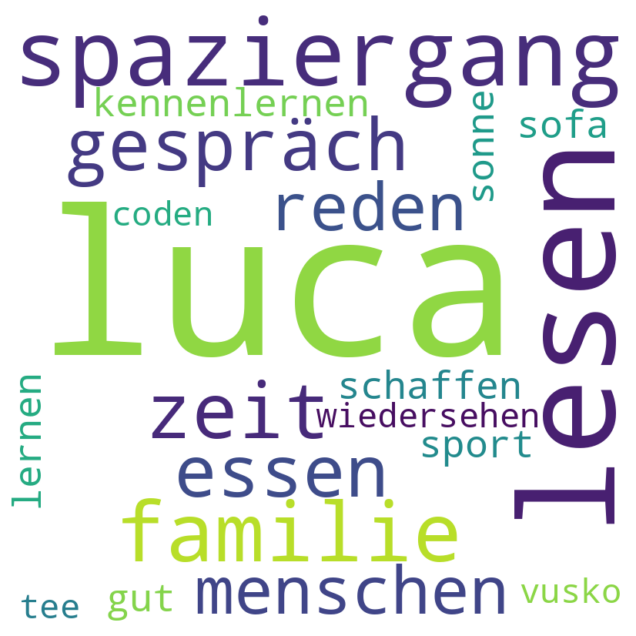

In [95]:
import nltk
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('punkt_tab')

# Start with defining all functions for pre-processing

# function to remove special characters like new line, non-numeric, non-letter and non-space characters
def rm_special_char(text):
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'[^a-z^ä^ü^ö^ß^é(\s]', '', text) #using regex to remove all characters that are non-numeric and not a lower case letter and not a space by replacing with ''
    text = re.sub(r'lucas', 'luca', text)
    text = text.strip()
    return text

# tokenizer function to tokenize the text
def tokenize(text):
    text = nltk.word_tokenize(text)
    return text

# function to remove stopwords
# Note participant 0 wrote their gratitude notes in german and participant 1 in english
def rm_stopwords(text):
    # removing german and english stopwords
    stop_words = stopwords.words('german')
    stop_words.extend(stopwords.words('english'))
    # adding some additional custom stopwords that we found in the data
    stop_words.extend(['beim', 'denen', 'viele', 'nan', 'e', 'al', 'wa', 'aufm', 'nice', 'good', 'lot', 'cool', 'much'])
    # removing stopwords
    text_without_stopwords = [word for word in text if word not in stop_words]
    return text_without_stopwords

# function to lemmatize the text using WordNetLemmatizer
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(text)):
        text[i] = lemmatizer.lemmatize(text[i], pos='n') #lemmatizing as noun
        text[i] = lemmatizer.lemmatize(text[i], pos='v') #lemmatizing as verb (if no corresponding form is found, the word remains unchanged)
    return text

# function to preprocess the text by applying all the functions above
def preprocess(text):
    text = str(text)
    text = text.lower()
    text = rm_special_char(text)
    text = tokenize(text)
    text = lemmatize(text)
    text = rm_stopwords(text)
    return text

# function to create a wordcloud from the word counts
def wordcloud_words(word_counts, num_words_to_diagram = 20):
    # filtering for the words that are most common
    word_counts_top_words = word_counts[:num_words_to_diagram]
    # Create a dictionary that maps words to their frequencies
    word_count_dict = {word: count for word, count in word_counts_top_words}

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=800, background_color='white')

    # Generate the word cloud
    wordcloud.generate_from_frequencies(word_count_dict)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')

    plt.axis("off")
    plt.show()

# load the actual gratitude entries
df = pd.read_csv('data/gratitude_entries-2025-02-17_jeelka.csv')

# preprocess the gratitude entries
preprocessed_entries = [preprocess(entry) for entry in df[('gratitude')]]
preprocessed_entries_flat = [word for lst in preprocessed_entries for word in lst]
word_count = nltk.FreqDist(preprocessed_entries_flat)
word_count_top_words = word_count.most_common(1000)
# barchart_words(word_count_top_words, 20)

# display the actual wordcloud
wordcloud_words(word_count_top_words, 20)

This was interesting for us to see which words are most common in the gratitude entries.
Showing us what we value and what we are grateful for on a daily basis.
A word cloud is a great way to visualize this.